<a href="https://colab.research.google.com/github/MohammadAghaei1/Generative-AI/blob/main/GANs_%26_VAEs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Libraries**

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import time
import torch

# **Loading dataset**

In [2]:
# LOAD AND PREPROCESS DATA
print("Loading MNIST data...")
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()

# Reshape from (60000, 28, 28) → (60000, 28, 28, 1)
# Add channel dimension for Conv2D (1 = grayscale)
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')

Loading MNIST data...
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


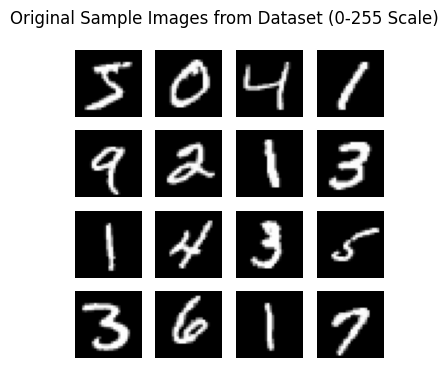

In [3]:
# Load a small sample of original MNIST images to avoid re-normalizing the main dataset
(original_display_images, _), (_, _) = tf.keras.datasets.mnist.load_data()

# Take the first 16 images for display and reshape them
original_display_images = original_display_images[:16].reshape(-1, 28, 28, 1)

plt.figure(figsize=(4, 4))
for i in range(original_display_images.shape[0]):
    plt.subplot(4, 4, i + 1)
    # Display images directly in their original [0, 255] scale
    plt.imshow(original_display_images[i, :, :, 0], cmap='gray', vmin=0, vmax=255)
    plt.axis('off')
plt.suptitle('Original Sample Images from Dataset (0-255 Scale)')
plt.show()

In [ ]:
# Normalize pixel values from [0, 255] → [-1, 1]
train_images = (train_images - 127.5) / 127.5

# Check the shape of the data
print(train_images.shape)

# Dataset parameters
BUFFER_SIZE = 60000
BATCH_SIZE = 128

#  - shuffle it
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE)

Loading MNIST data...
(60000, 28, 28, 1)


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cuda


# **Making Generator**

In [ ]:
def make_generator_model(noise_dim):
    model = tf.keras.Sequential()

    # Input: Random Noise
    # # Start with a dense layer that outputs a 7x7x128 tensor
    model.add(layers.Dense(7*7*128, use_bias=False, input_shape=(noise_dim,)))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((7, 7, 128)))

    # Upsample from 7x7 to 14x14
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU())

    # Upsample from 14x14 to 28x28
    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization(momentum=0.8))  #
    model.add(layers.LeakyReLU())

    # Refine 28x28 (Stride = 1)
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh'))

    model.summary()

    return model

In [ ]:
NOISE_DIM = 100
generator = make_generator_model(NOISE_DIM)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 6272)           │       627,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 6272)           │        25,088 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 14, 14, 128)    │       409,600 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 14, 14, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_15 (LeakyReLU)      │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 28, 28, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 28, 28, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_16 (LeakyReLU)      │ (None, 28, 28, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_8              │ (None, 28, 28, 1)      │         1,600 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,269,056 (4.84 MB)

 Trainable params: 1,256,128 (4.79 MB)

 Non-trainable params: 12,928 (50.50 KB)

# **Making Discriminator**

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()

    # --- Block 1: 32 Filters (Input) ---
    # Matches Code A: Conv2D(32) -> LeakyReLU -> Dropout
    model.add(layers.Conv2D(32, kernel_size=3, strides=2, padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))

    # --- Block 2: 64 Filters ---
    # Matches Code A: Conv2D(64) -> BN -> LeakyReLU -> Dropout
    model.add(layers.Conv2D(64, kernel_size=3, strides=2, padding='same'))
    # Note: I used padding='same' instead of manual ZeroPadding2D to prevent shape errors
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))

    # --- Block 3: 128 Filters ---
    # Matches Code A: Conv2D(128) -> BN -> LeakyReLU -> Dropout
    model.add(layers.Conv2D(128, kernel_size=3, strides=2, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))

    # --- Block 4: 256 Filters ---
    # Matches Code A: Conv2D(256) -> BN -> LeakyReLU -> Dropout
    # Note: Strides=1 here (just like Code A) to refine features without shrinking size
    model.add(layers.Conv2D(256, kernel_size=3, strides=1, padding='same'))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))

    # --- Output ---
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))

    model.summary()

    return model

In [ ]:
discriminator = make_discriminator_model()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 14, 14, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_17 (LeakyReLU)      │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 7, 7, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 7, 7, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_18 (LeakyReLU)      │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_19 (LeakyReLU)      │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 4, 4, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_20 (LeakyReLU)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │         4,097 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 393,729 (1.50 MB)

 Trainable params: 392,833 (1.50 MB)

 Non-trainable params: 896 (3.50 KB)

# **Loss functions and optimizers**

In [ ]:
# Binary cross-entropy loss for real/fake classification
# from_logits=False because discriminator uses sigmoid
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

def discriminator_loss(real_output, fake_output):
    """
    real_output: D(real images)  -> should be close to 1
    fake_output: D(fake images)  -> should be close to 0
    """
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)   # label 1 for real
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)  # label 0 for fake
    return real_loss + fake_loss

def generator_loss(fake_output):
    """
    fake_output: D(fake images)
    Generator wants D(fake) ≈ 1 (fool the discriminator)
    """
    return cross_entropy(tf.ones_like(fake_output), fake_output)  # want label 1 for fake


In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5)

# **Making DCGAN**

In [ ]:
@tf.function
def train_step(images):
    """
    Performs one training step on a batch of real images:
      - sample noise
      - generate fake images
      - compute discriminator and generator losses
      - update both networks
      - compute discriminator accuracy on real and fake
    """
    # Sample random noise for the generator: (batch_size, NOISE_DIM)
    # Here batch_size is fixed to 128, matching BATCH_SIZE
    noise = tf.random.normal([128, NOISE_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generate fake images from noise
        generated_images = generator(noise, training=True)

        # Discriminator output for real and fake images
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        # Compute losses
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    # Compute gradients
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # Apply gradients (update weights)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    # ----- Discriminator accuracies -----
    # Real images: correct if prediction > 0.5 (classified as real)
    real_pred = tf.cast(real_output > 0.5, tf.float32)
    real_acc = tf.reduce_mean(real_pred)  # fraction of real images correctly classified

    # Fake images: correct if prediction <= 0.5 (classified as fake)
    fake_pred_real = tf.cast(fake_output > 0.5, tf.float32)  # 1 if predicted real (wrong)
    fake_acc = tf.reduce_mean(1.0 - fake_pred_real)          # 1 - wrong = correct

    return gen_loss, disc_loss, real_acc, fake_acc


**Function for saving and plotting images**

In [ ]:
def generate_and_save_images(model, epoch, test_input):
    """
    Generate images from a fixed noise vector (test_input)
    and plot them in a 4x4 grid.
    """
    # Disable training behavior (e.g., batchnorm updates)
    predictions = model(test_input, training=False)

    plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)

        # Convert from [-1, 1] back to [0, 1] for display
        img_to_plot = (predictions[i, :, :, 0] + 1) / 2.0

        plt.imshow(img_to_plot, cmap='gray')
        plt.axis('off')

    plt.suptitle(f'Epoch {epoch}')
    plt.show()

# **Traning**

In [ ]:
def train(dataset, epochs):
    print("Starting training with Tanh [-1, 1]...")

    # Batch the dataset here (we kept it unbatched before)
    BATCH_SIZE = 128
    dataset = dataset.batch(BATCH_SIZE)

    for epoch in range(epochs):
        g_loss_metric = 0.0
        d_loss_metric = 0.0
        real_acc_metric = 0.0
        fake_acc_metric = 0.0
        steps = 0

        # Iterate over all batches in the dataset
        for image_batch in dataset:
            g_loss, d_loss, real_acc, fake_acc = train_step(image_batch)
            g_loss_metric += g_loss
            d_loss_metric += d_loss
            real_acc_metric += real_acc
            fake_acc_metric += fake_acc
            steps += 1

        # Average over all batches (epoch metrics)
        avg_g_loss = g_loss_metric / steps
        avg_d_loss = d_loss_metric / steps
        avg_real_acc = real_acc_metric / steps
        avg_fake_acc = fake_acc_metric / steps

        # Print losses + discriminator accuracies (in %)
        print(
            f'Epoch {epoch + 1}, '
            f'Gen Loss: {avg_g_loss:.4f}, '
            f'Disc Loss: {avg_d_loss:.4f}, '
            f'D(real)%: {avg_real_acc * 100:.1f}, '
            f'D(fake)%: {avg_fake_acc * 100:.1f}'
        )

        # Visualize 16 generated images from a fixed noise vector
        generate_and_save_images(generator, epoch + 1, seed)


**Running DCGAN**

Starting training with Tanh [-1, 1]...
Epoch 1, Gen Loss: 0.9447, Disc Loss: 1.3228, D(real)%: 61.9, D(fake)%: 61.5


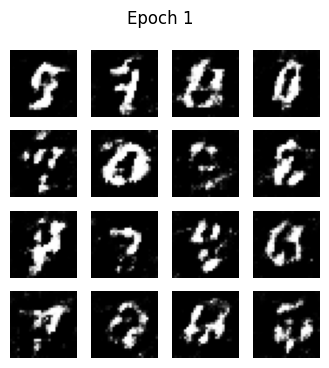

Epoch 2, Gen Loss: 1.1327, Disc Loss: 1.0932, D(real)%: 71.4, D(fake)%: 72.4


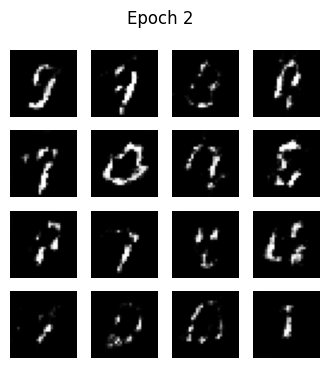

Epoch 3, Gen Loss: 1.1369, Disc Loss: 1.1429, D(real)%: 70.0, D(fake)%: 70.6


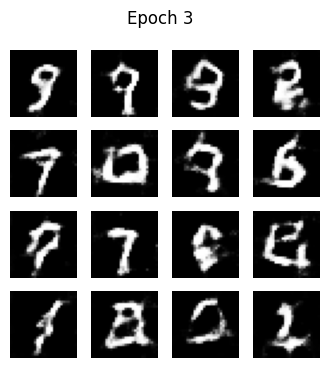

Epoch 4, Gen Loss: 1.0858, Disc Loss: 1.1388, D(real)%: 70.1, D(fake)%: 70.5


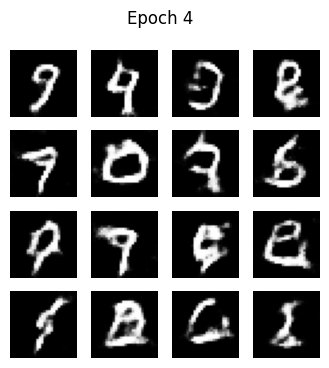

Epoch 5, Gen Loss: 1.1224, Disc Loss: 1.1028, D(real)%: 71.7, D(fake)%: 72.1


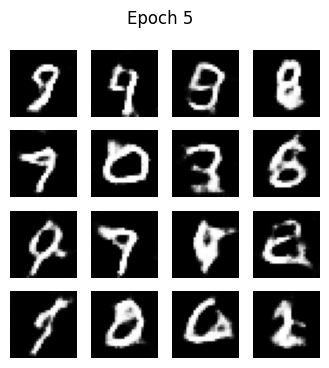

Epoch 6, Gen Loss: 1.1607, Disc Loss: 1.0617, D(real)%: 73.6, D(fake)%: 74.1


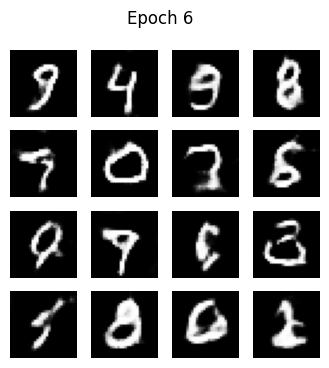

Epoch 7, Gen Loss: 1.2143, Disc Loss: 1.0099, D(real)%: 75.8, D(fake)%: 76.1


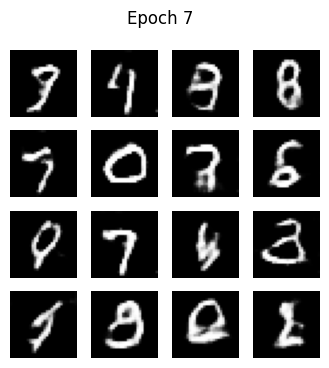

Epoch 8, Gen Loss: 1.2906, Disc Loss: 0.9563, D(real)%: 78.0, D(fake)%: 78.1


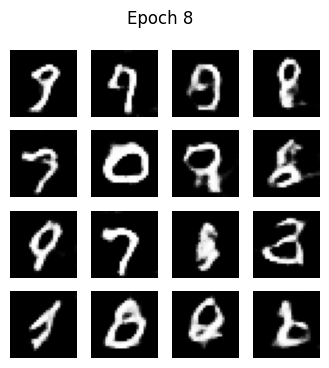

Epoch 9, Gen Loss: 1.3390, Disc Loss: 0.9323, D(real)%: 78.6, D(fake)%: 78.7


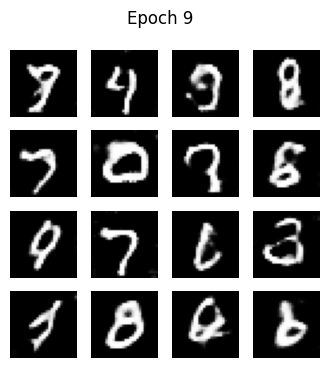

Epoch 10, Gen Loss: 1.4128, Disc Loss: 0.8898, D(real)%: 80.4, D(fake)%: 80.2


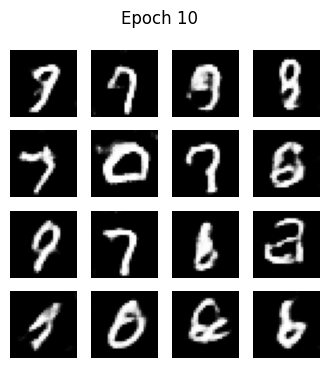

Epoch 11, Gen Loss: 1.4344, Disc Loss: 0.8875, D(real)%: 80.0, D(fake)%: 80.2


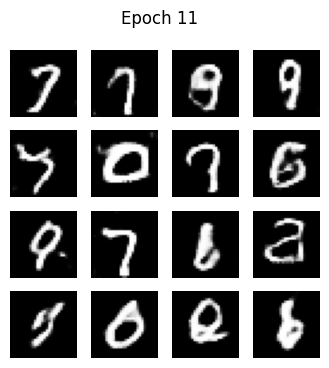

Epoch 12, Gen Loss: 1.4675, Disc Loss: 0.8705, D(real)%: 80.6, D(fake)%: 80.6


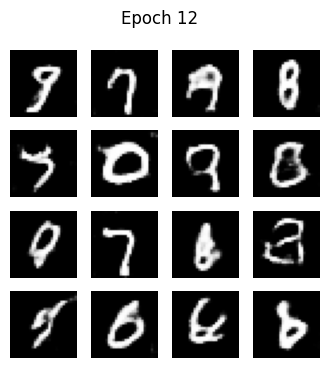

Epoch 13, Gen Loss: 1.4787, Disc Loss: 0.8690, D(real)%: 80.6, D(fake)%: 80.5


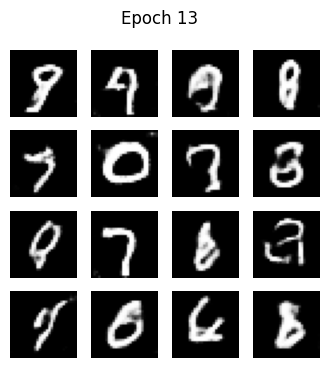

Epoch 14, Gen Loss: 1.5111, Disc Loss: 0.8593, D(real)%: 80.7, D(fake)%: 80.9


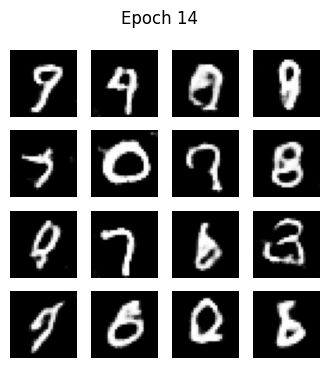

Epoch 15, Gen Loss: 1.5255, Disc Loss: 0.8597, D(real)%: 80.6, D(fake)%: 80.7


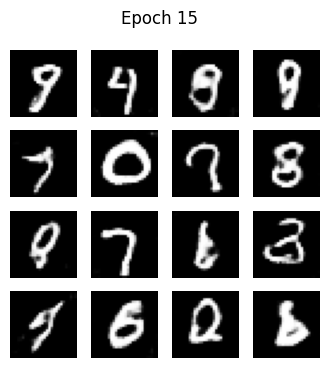

Epoch 16, Gen Loss: 1.5196, Disc Loss: 0.8703, D(real)%: 80.1, D(fake)%: 80.2


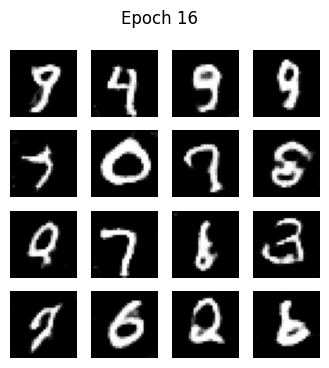

Epoch 17, Gen Loss: 1.5328, Disc Loss: 0.8759, D(real)%: 80.0, D(fake)%: 79.9


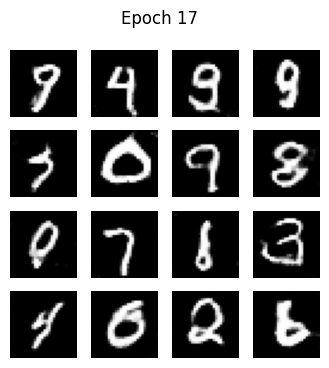

Epoch 18, Gen Loss: 1.5593, Disc Loss: 0.8724, D(real)%: 80.0, D(fake)%: 80.1


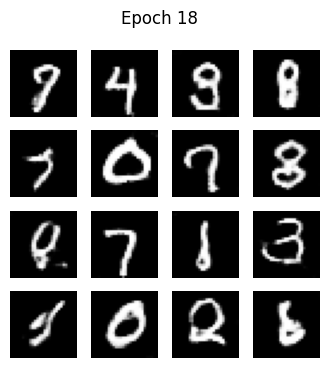

Epoch 19, Gen Loss: 1.5440, Disc Loss: 0.8787, D(real)%: 79.6, D(fake)%: 79.7


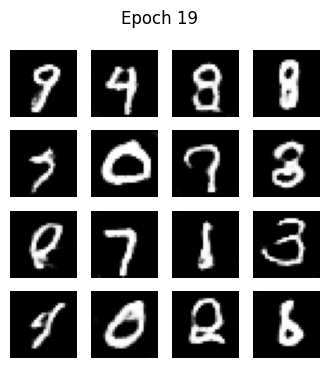

Epoch 20, Gen Loss: 1.5674, Disc Loss: 0.8725, D(real)%: 80.1, D(fake)%: 79.8


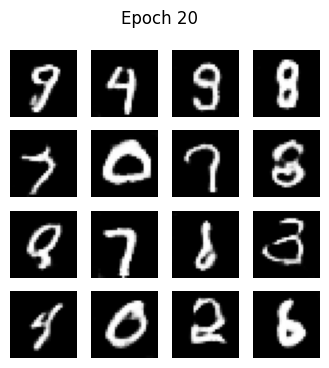

Epoch 21, Gen Loss: 1.5910, Disc Loss: 0.8621, D(real)%: 80.3, D(fake)%: 80.1


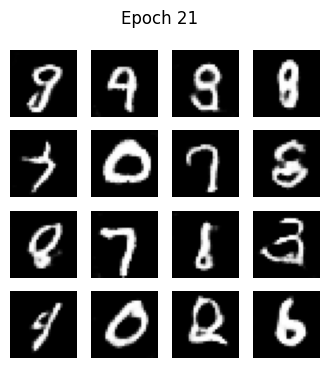

Epoch 22, Gen Loss: 1.5885, Disc Loss: 0.8604, D(real)%: 80.0, D(fake)%: 80.3


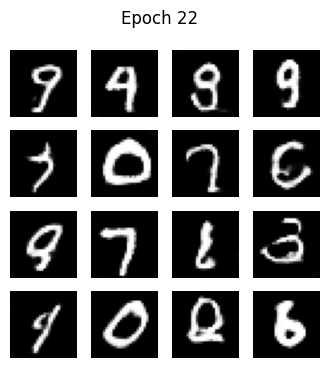

Epoch 23, Gen Loss: 1.6041, Disc Loss: 0.8600, D(real)%: 80.5, D(fake)%: 80.3


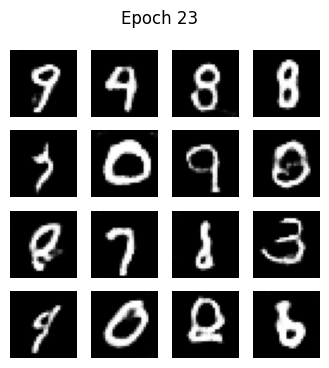

Epoch 24, Gen Loss: 1.6179, Disc Loss: 0.8669, D(real)%: 80.0, D(fake)%: 80.0


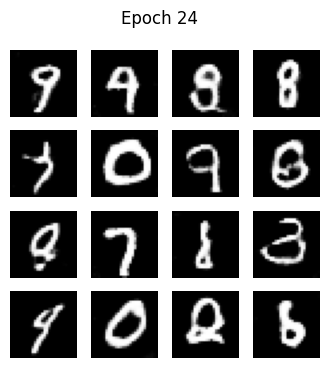

Epoch 25, Gen Loss: 1.6173, Disc Loss: 0.8522, D(real)%: 80.5, D(fake)%: 80.8


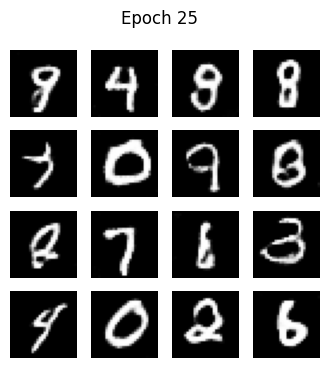

Epoch 26, Gen Loss: 1.6338, Disc Loss: 0.8724, D(real)%: 80.0, D(fake)%: 79.7


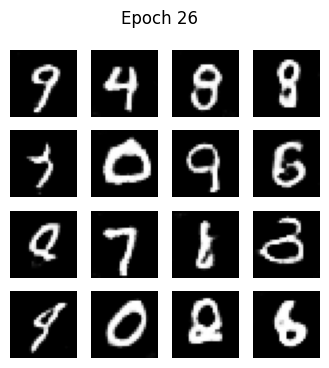

Epoch 27, Gen Loss: 1.6274, Disc Loss: 0.8561, D(real)%: 80.5, D(fake)%: 80.3


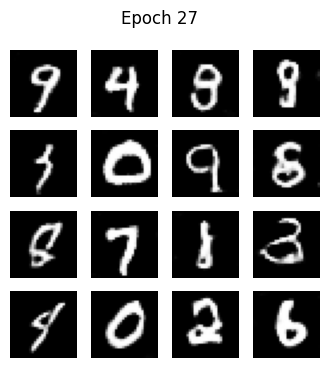

Epoch 28, Gen Loss: 1.6458, Disc Loss: 0.8515, D(real)%: 80.3, D(fake)%: 80.6


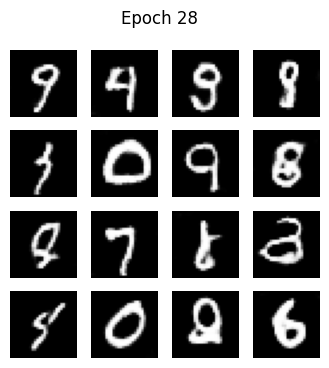

Epoch 29, Gen Loss: 1.6562, Disc Loss: 0.8636, D(real)%: 79.9, D(fake)%: 80.1


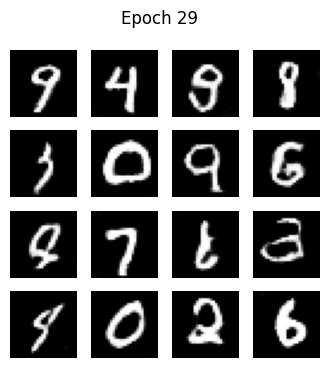

Epoch 30, Gen Loss: 1.6494, Disc Loss: 0.8781, D(real)%: 79.5, D(fake)%: 79.2


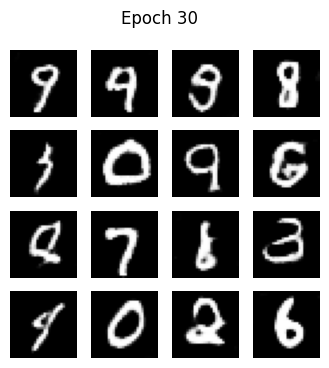

Epoch 31, Gen Loss: 1.6612, Disc Loss: 0.8776, D(real)%: 79.6, D(fake)%: 79.4


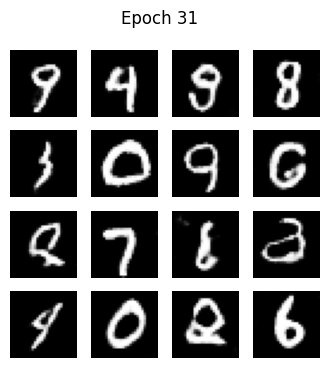

Epoch 32, Gen Loss: 1.6720, Disc Loss: 0.8474, D(real)%: 80.7, D(fake)%: 80.5


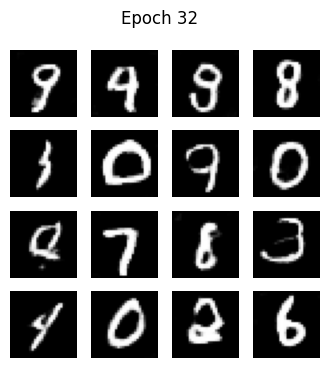

Epoch 33, Gen Loss: 1.6894, Disc Loss: 0.8428, D(real)%: 80.8, D(fake)%: 80.7


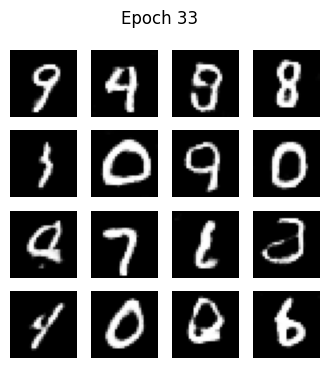

Epoch 34, Gen Loss: 1.6922, Disc Loss: 0.8587, D(real)%: 80.2, D(fake)%: 80.1


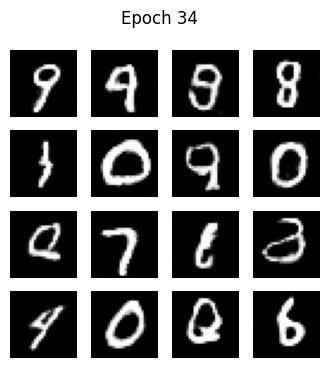

Epoch 35, Gen Loss: 1.6834, Disc Loss: 0.8633, D(real)%: 80.2, D(fake)%: 80.2


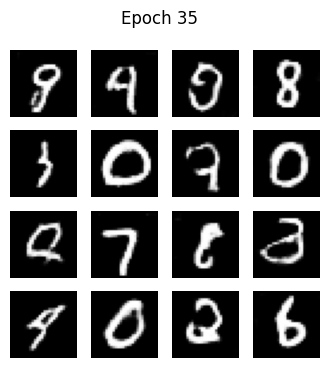

Epoch 36, Gen Loss: 1.6991, Disc Loss: 0.8454, D(real)%: 80.6, D(fake)%: 80.6


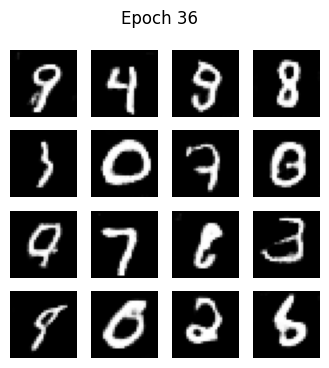

Epoch 37, Gen Loss: 1.6897, Disc Loss: 0.8827, D(real)%: 79.4, D(fake)%: 79.2


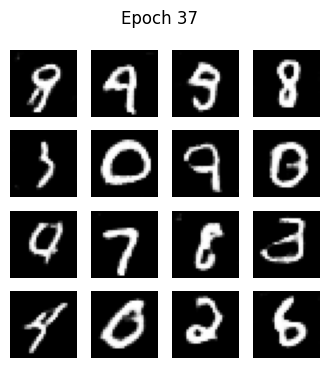

Epoch 38, Gen Loss: 1.7091, Disc Loss: 0.8490, D(real)%: 80.6, D(fake)%: 80.5


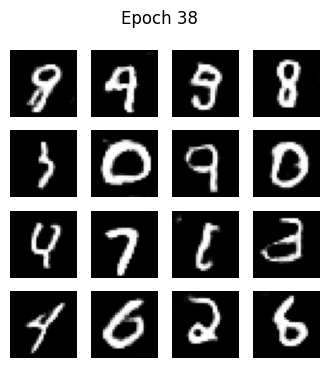

Epoch 39, Gen Loss: 1.7044, Disc Loss: 0.8536, D(real)%: 80.0, D(fake)%: 80.5


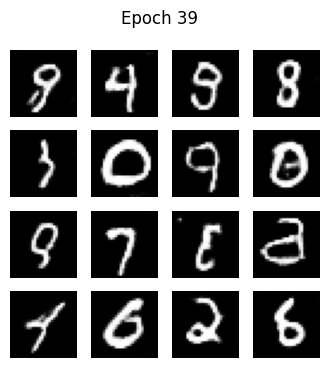

Epoch 40, Gen Loss: 1.7309, Disc Loss: 0.8617, D(real)%: 80.1, D(fake)%: 79.7


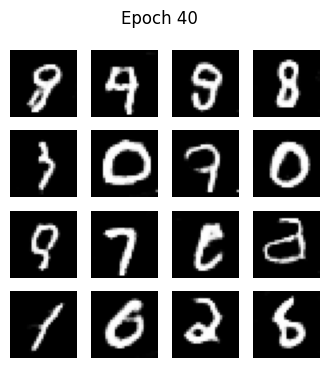

Epoch 41, Gen Loss: 1.7284, Disc Loss: 0.8466, D(real)%: 80.3, D(fake)%: 80.4


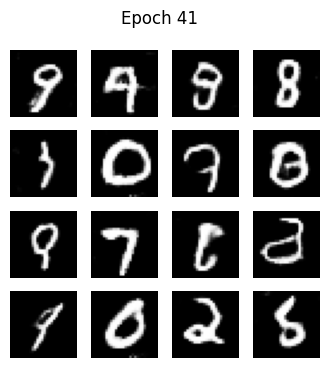

Epoch 42, Gen Loss: 1.7405, Disc Loss: 0.8450, D(real)%: 80.5, D(fake)%: 80.7


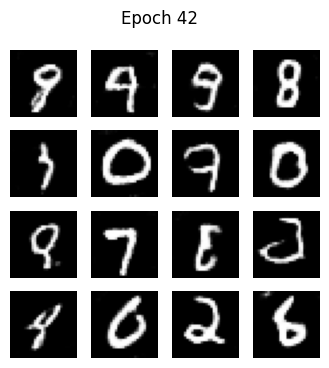

Epoch 43, Gen Loss: 1.7075, Disc Loss: 0.8610, D(real)%: 80.2, D(fake)%: 80.1


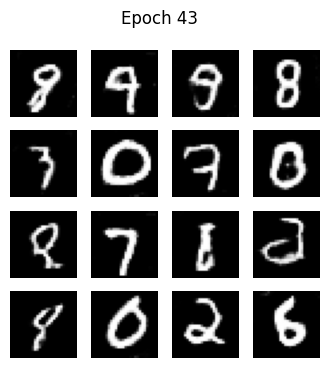

Epoch 44, Gen Loss: 1.7231, Disc Loss: 0.8648, D(real)%: 79.8, D(fake)%: 79.8


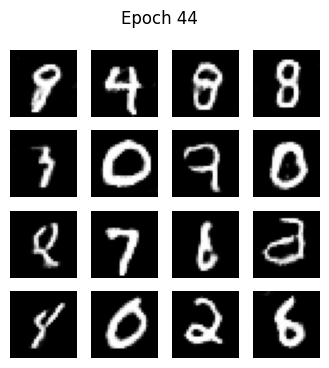

Epoch 45, Gen Loss: 1.7346, Disc Loss: 0.8493, D(real)%: 80.3, D(fake)%: 80.2


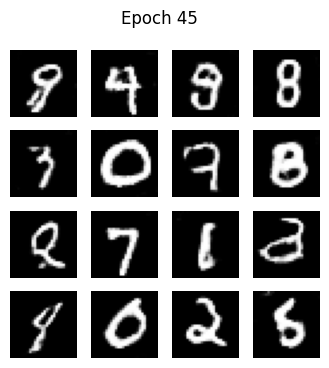

Epoch 46, Gen Loss: 1.7560, Disc Loss: 0.8218, D(real)%: 81.4, D(fake)%: 81.4


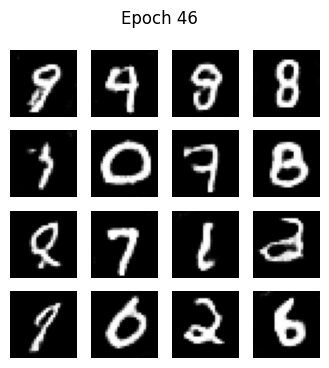

Epoch 47, Gen Loss: 1.7594, Disc Loss: 0.8629, D(real)%: 80.1, D(fake)%: 80.0


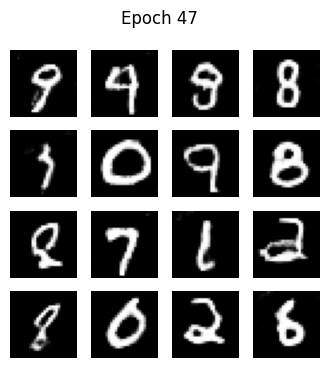

Epoch 48, Gen Loss: 1.7397, Disc Loss: 0.8657, D(real)%: 80.1, D(fake)%: 79.8


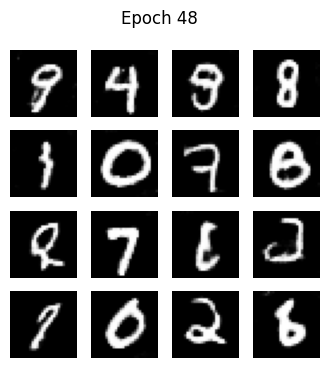

Epoch 49, Gen Loss: 1.7617, Disc Loss: 0.8338, D(real)%: 81.1, D(fake)%: 80.9


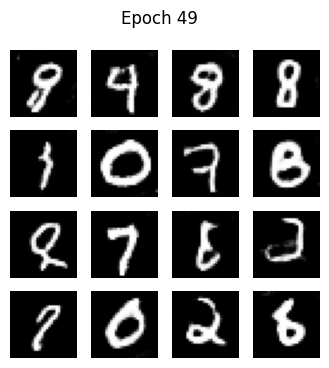

Epoch 50, Gen Loss: 1.7631, Disc Loss: 0.8497, D(real)%: 80.5, D(fake)%: 80.1


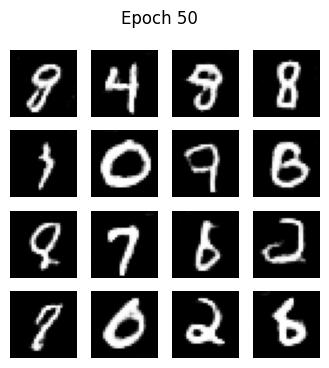

In [ ]:
# Fixed noise vector used for monitoring generator progress
seed = tf.random.normal([16, NOISE_DIM])
train(train_dataset, epochs=50)

In [ ]:
import numpy as np
import tensorflow as tf
from scipy.linalg import sqrtm
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input

# --- 1. Load InceptionV3 Model ---
# We use this pretrained model to extract features for FID calculation
inception_model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

# --- 2. Helper Functions (Robust & Fixed) ---
def scale_and_resize_images(images):
    """
    Resizes images to 299x299 and converts them to RGB.
    Input images should be in the range [0, 255].
    """
    images_list = []
    for img in images:
        # Convert numpy array to Tensor to avoid 'get_shape' errors
        img = tf.convert_to_tensor(img)

        # --- FIX: If image is 2D (H, W), add the channel dimension (H, W, 1) ---
        if len(img.shape) == 2:
            img = tf.expand_dims(img, axis=-1)
        # -----------------------------------------------------------------------

        # If image is grayscale (1 channel), convert to RGB (3 channels)
        if img.shape[-1] == 1:
            img = tf.image.grayscale_to_rgb(img)

        # Resize to 299x299 for InceptionV3
        img = tf.image.resize(img, [299, 299])
        images_list.append(img)

    # 'preprocess_input' handles the internal normalization for Inception
    return preprocess_input(np.array(images_list))

def calculate_fid(model, real_images, generated_images):
    # Resize and preprocess both sets
    real_images_resized = scale_and_resize_images(real_images)
    gen_images_resized = scale_and_resize_images(generated_images)

    # Extract features
    act1 = model.predict(real_images_resized, verbose=0)
    act2 = model.predict(gen_images_resized, verbose=0)

    # Calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)

    # Calculate squared difference of means
    ssdiff = np.sum((mu1 - mu2)**2.0)

    # Calculate sqrt of product of covariances
    covmean = sqrtm(sigma1.dot(sigma2))

    # Handle numerical instability (complex numbers)
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    # Final FID formula
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

# --- 3. Prepare Data ---

# A) Real Images (MNIST)
print("Loading real images...")
(train_images, _), (_, _) = tf.keras.datasets.mnist.load_data()

# IMPORTANT: We keep data in [0, 255] range. We do NOT divide by 127.5 here.
train_images = train_images.astype('float32')

# Select 5000 random real images for better statistical accuracy
random_indices = np.random.randint(0, train_images.shape[0], 5000)
real_batch = train_images[random_indices]

# B) Generated Images
print("Generating fake images...")
# Define NOISE_DIM if not already defined in your notebook
if 'NOISE_DIM' not in globals():
    NOISE_DIM = 100

noise = tf.random.normal([5000, NOISE_DIM])
gen_batch = generator(noise, training=False)

# IMPORTANT: Generator output is [-1, 1]. We must convert it back to [0, 255].
gen_batch = (gen_batch * 127.5) + 127.5

# --- 4. Calculate FID ---
print("Calculating FID (This may take a minute due to resizing)...")
fid_score = calculate_fid(inception_model, real_batch, gen_batch)

print("-" * 30)
print(f"Final FID Score: {fid_score:.4f}")
print("-" * 30)